<a href="https://colab.research.google.com/github/menezesglesia/Tarefas-P-s/blob/main/Glesia%20Alves%20Menezes%20_Trilha_7_Base_ANAC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Blibliotecas & Downloads


In [100]:
import pandas as pd
import math

import networkx as nx
import matplotlib.pyplot as plt


# Monta arquivo para trabalho

In [101]:
#cálculo dos nós
#nx.diameter(G)

#Distancia entre aeroportos >> qual mais distante
sorted(list(nx.shortest_path_length(G)))

# Qual aeroporto voa para mais cidades distintas
d = list(nx.degree(G))
d.sort(key=lambda x:x[1])
d

#Grau médio
soma = 0
conta = 0
for aeroporto, grau in d:
  soma =  soma + grau
  conta = conta +1

print("Grau medio", soma/conta)





Grau medio 10.135593220338983


### Dados de aeroporto

In [102]:
airport_col = ['ID', 'Name', 'City', 'Country','IATA', 'ICAO', 'Lat', 'Long', 'Alt', 
	               'Timezone', 'DST', 'Tz database time zone', 'type', 'source']
airport_df = pd.read_csv("https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat",
	                        names = airport_col, index_col = 0)
airport_df.head(20)

,Name,City,Country,IATA,ICAO,Lat,Long,Alt,Timezone,DST,Tz database time zone,type,source
ID,,,,,,,,,,,,,
1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports
4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports
5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby,airport,OurAirports
6,Wewak International Airport,Wewak,Papua New Guinea,WWK,AYWK,-3.583830,143.669006,19,10,U,Pacific/Port_Moresby,airport,OurAirports
7,Narsarsuaq Airport,Narssarssuaq,Greenland,UAK,BGBW,61.160500,-45.425999,112,-3,E,America/Godthab,airport,OurAirports
8,Godthaab / Nuuk Airport,Godthaab,Greenland,GOH,BGGH,64.190903,-51.678101,283,-3,E,America/Godthab,airport,OurAirports
9,Kangerlussuaq Airport,Sondrestrom,Greenland,SFJ,BGSF,67.012222,-50.711603,165,-3,E,America/Godthab,airport,OurAirports


## Dados das rotas

### Arquivo com geolocalizacao

In [103]:
def monta_pos(IATA):
  airport_pos_df = airport_df.loc[airport_df['IATA'].isin(IATA)][['IATA', 'Lat', 'Long']]
  airport_pos_df.reset_index(inplace=True)
  
  pos = {}
  for index, elem in enumerate (airport_pos_df['IATA']):    
    pos[elem] =  (airport_pos_df.loc[index ,'Long'], airport_pos_df.loc[index ,'Lat']) 

  found = len(airport_pos_df.loc[~airport_pos_df['Lat'].isnull()])
  print(f'{found} Aeroportos com Lat, Long')  

  return pos
  

### Monta topo de rotas, e prepara a lista de aeroportos

In [104]:
def routes_top(routes_grouped_df, top):
  routes_grouped_df_top = routes_grouped_df.loc[routes_grouped_df['counts'] > top]  

  IATA_dest = set(routes_grouped_df_top['IATA_dest'].unique())
  print(f'{len(IATA_dest)} Aeroportos encontrados destinos')

  IATA_orig = set(routes_grouped_df_top['IATA_orig'].unique())  
  print(f'{len(IATA_orig)} Aeroportos encontrados origem')

  IATA = IATA_dest.union(IATA_orig)
  print(f'{len(IATA)} Aeroportos encontrados total')
  return IATA, routes_grouped_df_top

### Função principal de montagem de rotas

In [105]:
def monta_rotas(ano, top):
  ######################################################
  # Define nomes mais faceis de manipular para a tabela
  ######################################################
  '''
  0 'ICAO Empresa Aérea'	'Número Voo'	'Código Autorização (DI)'	'Código Tipo Linha'	'ICAO Aeródromo Origem'	'ICAO Aeródromoo Destino'	
  'Partida Prevista'	'Partida Real'	'Chegada Prevista'	'Chegada Real'	
  'Situação Voo'	'Código Justificativa'	'ano'	'mes'                 
  '''

  routes_col = ['company_id', 'flight_no', 'auth_code', 'line_code','ICAO_orig', 'ICAO_dest', 
                'depature_estimated', 'depature_time', 'arrival_estimated', 'arriaval_time', 
                'flight_status', 'flight_status_cause_code', 'ano', 'mes']

  #Carrega a lista do ano, porém eliminando os voos cancelados
  # routes_df = pd.read_csv(f"/content/drive/MyDrive/VRA/VRA_ANO_{ano}.csv"
  #                           ,header=0 ,names = routes_col, index_col = 0) #
  routes_df = pd.read_csv(f"https://github.com/lucianomcsilva/VRA/blob/main/VRA_ANO_2018.csv.zip?raw=true"
                            ,compression='zip' ,header=0 ,names = routes_col, index_col = 0) #

  routes_df = routes_df.loc[routes_df['flight_status'] != 'CANCELADO']

  #Agrupa, mantendo so o que entrara no grafo
  routes_grouped_df = routes_df.groupby(['ICAO_orig', 'ICAO_dest']).size().reset_index(name='counts')                          
  
  ######################################################################
  #Jaz a junção com o Airport.dat para trocar para o codigo de 3 letras
  ######################################################################
  #Join origem
  routes_grouped_df = routes_grouped_df.merge(airport_df[['ICAO', 'IATA', 'Lat', 'Long', 'Country']], how='left', left_on='ICAO_orig', right_on='ICAO')
  routes_grouped_df = routes_grouped_df[['IATA', 'Country', 'ICAO_dest', 'counts']]
  routes_grouped_df.rename(columns={'IATA': 'IATA_orig', 'Country': 'Country_orig'}, inplace = True)
  #Join Destino
  routes_grouped_df = routes_grouped_df.merge(airport_df[['ICAO', 'IATA', 'Lat', 'Long', 'Country']], how='left', left_on='ICAO_dest', right_on='ICAO')
  routes_grouped_df = routes_grouped_df[['IATA_orig', 'Country_orig', 'IATA', 'Country', 'counts']]
  routes_grouped_df.rename(columns={'IATA': 'IATA_dest', 'Country': 'Country_dest'}, inplace = True)

  #Filtra somente Brazil, e mantem somente as colunas necessarias
  routes_grouped_df = (routes_grouped_df
                        .loc[routes_grouped_df['Country_orig'] == 'Brazil']
                        .loc[routes_grouped_df['Country_dest'] == 'Brazil']
                        .loc[routes_grouped_df['IATA_orig'] != routes_grouped_df['IATA_dest']]
                        .loc[routes_grouped_df['IATA_orig'].str.len() == 3]
                        .loc[routes_grouped_df['IATA_dest'].str.len() == 3]
                        .sort_values(by=['counts'], ascending=False)
                      )
  routes_grouped_df = routes_grouped_df[['IATA_orig', 'IATA_dest', 'counts']]  
  
  #prepara os DataFrames que serão utilizados
  IATA, routes_grouped_df_top = routes_top(routes_grouped_df, top)
  pos = monta_pos(IATA)
  return routes_grouped_df_top, pos

  #lista de aeroportos nao encontrados
  #routes_grouped_df.loc[routes_grouped_df['ICAO'].isnull()]['ICAO_orig'].to_list()
  #df_anac_2015 = pd.read_csv(f"VRA_ANO_2015.csv")


# Grafos

## monta o grafo

In [131]:
def desenha_grafo2(ano, type='Map', all=True):
  G = nx.Graph()
  pos = {}
  airport_brasil_df = airport_df.loc[airport_df['Country'] == 'Brazil'].loc[airport_df['IATA'].str.len() == 3]
  airport_brasil_df.reset_index(inplace=True)

  if all == True:
    for index, elem in enumerate(airport_brasil_df['IATA']):
      #G.add_node(airport_brasil_df.loc[index, 'IATA'])
      pos[elem] =  (airport_brasil_df.loc[index ,'Long'], airport_brasil_df.loc[index ,'Lat']) 


  #ignorar pos, ja adicionei todos os aeroportos
  routes, pos_ignore = monta_rotas(ano, 1)
  routes.reset_index(inplace=True)
  for index, elem in enumerate(routes['IATA_orig']):
    G.add_edge(routes.loc[index, 'IATA_orig'], routes.loc[index, 'IATA_dest'])


  if all == False:
      
    #Dois aeroportos desconexos. Nao faz sentido remover caso desenhe todos os aeroportos, pois haverão outros disconexos (sem voo algum, valencia = 0)
    G.remove_node('SXO')
    G.remove_node('CFO')

  options = {
      "font_size": 14,
      "node_size": 1000,
      "node_color": "#336699CC",
      "edgecolors": "#002060",
      "edge_color": "#D34817",
      "linewidths": 0.5,
      "width": [1+int(math.log(x, 30)) for x in routes['counts'].to_list()],
      "with_labels": True
  }

  plt.figure(figsize = (15,15))
  if type == 'Map':
    nx.draw_networkx(G, pos, **options)
    plt.savefig(f'brasil_2_map_{ano}.png', dpi=30)
  elif type == 'Random':
    nx.draw_random(G, **options)
    plt.savefig(f'brasil_2__random_{ano}.png', dpi=50)    
  elif type == 'Best':
    nx.draw(G, **options)
    plt.savefig(f'brasil_2_best_{ano}.png', dpi=50)        
  else:
    nx.draw_shell(G, **options)
    plt.savefig(f'brasil_2_shell_{ano}.png', dpi=50)

  return G
  #G.add_node(1)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


117 Aeroportos encontrados destinos
116 Aeroportos encontrados origem
118 Aeroportos encontrados total
118 Aeroportos com Lat, Long


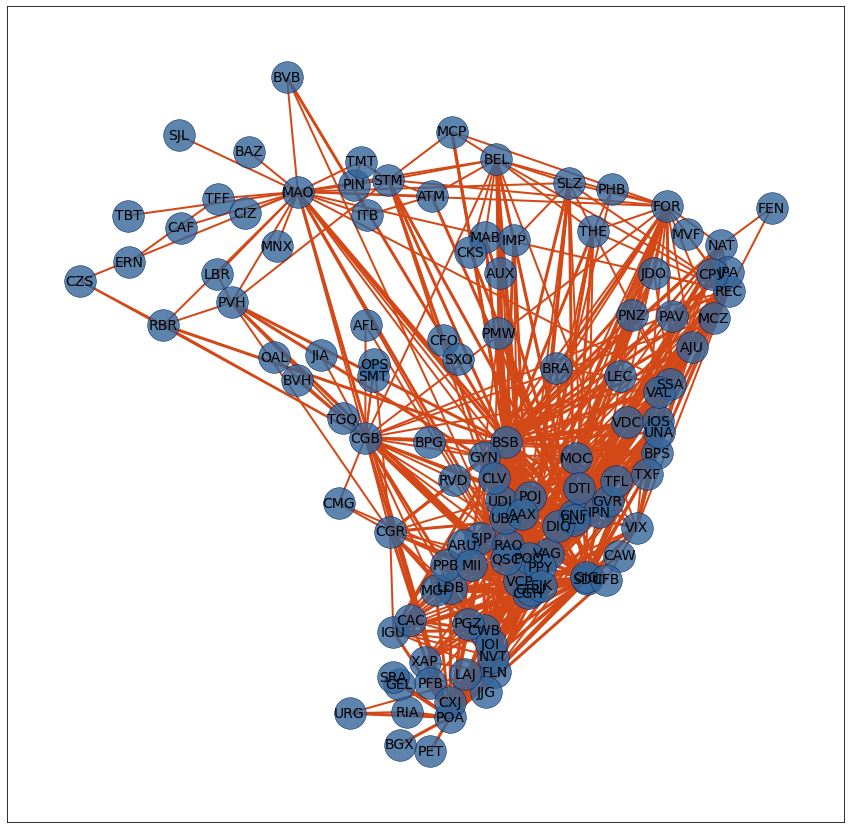

In [115]:
G = desenha_grafo2(2018, 'Map')


In [139]:
nx.diameter(G)

5

#Quais são os dois aeroportos que precisavam em 2018 de mais escalas para se interligarem?
R: 'ERN': 4, e 'BAZ': 4, partindo de 'BGX': 4,
'BVH': 4,'CAF': 4,'CAW': 4,'CIZ': 4,'CZS': 4,'DTI': 4,'FEN': 4'GEL': 4,'ITB': 4,'JIA': 4,'LBR': 4,'LEC': 4,

In [ ]:
#Distancia entre aeroportos >> qual mais distante
sorted(list(nx.shortest_path_length(G)))

#Qual o grau médio, ou seja, número de outros aeroportos conectados, dos aeroportos brasileiros com voos em 2018?
R: 10

In [120]:
soma = 0
conta = 0
for aeroporto, grau in d:
  soma =  soma + grau
  conta = conta +1

print("Grau medio", soma/conta)

Grau medio 10.135593220338983


#Qual aeroporto voa para mais cidades distintas
R: ('VCP', 67) Aeroporto de Viracorpos, voando para 67 cidades distintas.

In [118]:
d = list(nx.degree(G))
#d.sort(key=lambda x:x[1])
d.sort(reverse= True)
print(d)

[('XAP', 9), ('VIX', 18), ('VDC', 6), ('VCP', 67), ('VAL', 1), ('VAG', 5), ('URG', 3), ('UNA', 8), ('UDI', 17), ('UBA', 7), ('TXF', 3), ('TMT', 3), ('THE', 11), ('TGQ', 1), ('TFL', 1), ('TFF', 2), ('TBT', 1), ('SXO', 1), ('STM', 11), ('SSA', 36), ('SRA', 1), ('SMT', 1), ('SLZ', 12), ('SJP', 11), ('SJL', 1), ('SJK', 9), ('SDU', 23), ('RVD', 1), ('RIA', 2), ('REC', 32), ('RBR', 5), ('RAO', 24), ('QSC', 8), ('PVH', 10), ('PPY', 3), ('PPB', 6), ('POO', 3), ('POJ', 3), ('POA', 38), ('PNZ', 8), ('PMW', 10), ('PLU', 20), ('PIN', 2), ('PHB', 2), ('PGZ', 1), ('PFB', 4), ('PET', 1), ('PAV', 2), ('OPS', 2), ('OAL', 1), ('NVT', 13), ('NAT', 17), ('MVF', 1), ('MOC', 8), ('MNX', 1), ('MII', 1), ('MGF', 12), ('MCZ', 20), ('MCP', 5), ('MAO', 30), ('MAB', 6), ('LEC', 1), ('LDB', 18), ('LBR', 2), ('LAJ', 1), ('JPA', 12), ('JOI', 12), ('JJG', 2), ('JIA', 1), ('JDO', 7), ('ITB', 2), ('IPN', 5), ('IOS', 10), ('IMP', 6), ('IGU', 23), ('GYN', 23), ('GVR', 3), ('GRU', 53), ('GIG', 42), ('GEL', 1), ('FOR', 26)